## Train Stations in Europe

Do better understand the distribution of Train Infrastructure in Europe the following dataset is chosen to:
1. Visualize Station Infrastructure
2. Assist in Network traveltime estimation
3. Identify good and bad connected regions

The Dataset contributes to the overarching research question in the following ways:

### CRISP-DM Step 1: Business Understanding

We focus on understanding European rail accessibility to support travel-time estimation and
identify well- and under-connected regions. This notebook implements the data understanding
and preparation stages needed to answer those questions reliably.


### Imports

In [ ]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
import notebook
import jupyter
from pathlib import Path
import math
import matplotlib.pyplot as plt
import pandas as pd

### CRISP-DM Step 2: Data Understanding

Goal: collect the data, describe its structure, explore distributions, and assess quality to
inform cleaning and feature decisions.


#### 2.1 Data Collection (Data Loading)


In [2]:
data_path = Path('..') / 'Raw_Data' / 'train_stations_europe.csv'

# Read with explicit dtypes to avoid mixed-type warnings
# Keep identifiers as strings and UIC as nullable integer

dtype_map = {
    'uic': 'Int64',
    'entur_id': 'string',
    'trenord_id': 'string',
    'cercanias_id': 'string',
    'cercanias_hub_id': 'string',
}

df_stations = pd.read_csv(data_path, dtype=dtype_map, low_memory=False)

if 'id' in df_stations.columns:
    df_stations.set_index('id', inplace=True)

# Filter to EU-27 once at the start to guide downstream preprocessing
EU27 = {
    'AT','BE','BG','HR','CY','CZ','DK','EE','FI','FR','DE','GR','HU','IE','IT',
    'LV','LT','LU','MT','NL','PL','PT','RO','SK','SI','ES','SE'
}

before_eu = len(df_stations)
df_stations = df_stations[df_stations['country'].isin(EU27)].copy()
print('Dropped non-EU27 rows:', before_eu - len(df_stations))

df_stations.head()


Dropped non-EU27 rows: 26563


,name,name_norm,uic,latitude,longitude,parent_station_id,country,time_zone,is_city,is_main_station,is_airport,entur_id,entur_is_enabled,trenord_id,cercanias_id,cercanias_hub_id,cercanias_is_enabled
id,,,,,,,,,,,,,,,,,
1,Château-Arnoux – St-Auban,Chateau-Arnoux - St-Auban,<NA>,44.081790,6.001625,NaN,FR,Europe/Paris,True,False,False,<NA>,False,<NA>,<NA>,<NA>,False
2,Château-Arnoux – St-Auban,Chateau-Arnoux - St-Auban,8775123,44.061565,5.997373,1.0,FR,Europe/Paris,False,True,False,<NA>,False,<NA>,<NA>,<NA>,False
3,Château-Arnoux Mairie,Chateau-Arnoux Mairie,8775122,44.063863,6.011248,1.0,FR,Europe/Paris,False,False,False,<NA>,False,<NA>,<NA>,<NA>,False
4,Digne-les-Bains,Digne-les-Bains,<NA>,44.350000,6.350000,NaN,FR,Europe/Paris,True,False,False,<NA>,False,<NA>,<NA>,<NA>,False
6,Digne-les-Bains,Digne-les-Bains,8775149,44.088710,6.222982,4.0,FR,Europe/Paris,False,True,False,<NA>,False,<NA>,<NA>,<NA>,False


Result: data is loaded with explicit dtypes, indexed by station id, and scoped to EU-27 to
match the project focus and reduce downstream noise.


#### 2.2 Data Description (Initial Inspection)


In [3]:
# list unique countries
sorted(df_stations['country'].dropna().unique())

['AT',
 'BE',
 'BG',
 'CY',
 'CZ',
 'DE',
 'DK',
 'EE',
 'ES',
 'FI',
 'FR',
 'GR',
 'HR',
 'HU',
 'IE',
 'IT',
 'LT',
 'LU',
 'LV',
 'MT',
 'NL',
 'PL',
 'PT',
 'RO',
 'SE',
 'SI',
 'SK']

In this step we profile the schema and content to understand what each field represents,
identify redundancy, and surface early quality risks that will guide preparation choices.


##### 2.2.1 Columns Inspection & Understanding


In [4]:
# brief overview of the dataframe
print(f"Dataframe info: {"-"*50}")
print(df_stations.info())
print(f"{"-"*70}")

Dataframe info: --------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 43961 entries, 1 to 74737
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  43960 non-null  object 
 1   name_norm             43960 non-null  object 
 2   uic                   20402 non-null  Int64  
 3   latitude              42231 non-null  float64
 4   longitude             42231 non-null  float64
 5   parent_station_id     4279 non-null   float64
 6   country               43961 non-null  object 
 7   time_zone             43961 non-null  object 
 8   is_city               43961 non-null  bool   
 9   is_main_station       43961 non-null  bool   
 10  is_airport            43961 non-null  bool   
 11  entur_id              5 non-null      string 
 12  entur_is_enabled      43961 non-null  bool   
 13  trenord_id            0 non-null      string 
 14  cercania

##### Analysis: Column Inspection & Understanding

The Trains in Europe consists of the following Columns:

| Name | Brief contextual description | dtype | Data category |
|------|------------------------------|-------|---------------|
| id | Internal unique station identifier (primary key) | integer / numeric | Nominal |
| name | Local station name including accents and special characters | object | Nominal |
| name_norm | Latinised / normalised version of the station name | object | Nominal |
| uic | UIC (International Union of Railways) station code | float64 | Nominal |
| latitude | Geographic latitude of the station | float64 | Ratio |
| longitude | Geographic longitude of the station | float64 | Ratio |
| parent_station_id | Reference to a meta-station identifier | float64 | Nominal |
| country | ISO 3166-1 alpha-2 country code | object | Nominal |
| time_zone | Time zone identifier (IANA / Olson format) | object | Nominal |
| is_city | Indicates whether the station is classified as a city station (unreliable) | bool | Nominal (binary) |
| is_main_station | Indicates whether the station is a main station (unreliable) | bool | Nominal (binary) |
| is_airport | Indicates whether the station is associated with an airport | bool | Nominal (binary) |
| entur_id | External identifier from the Entur system | object | Nominal |
| entur_is_enabled | Indicates whether Entur integration is enabled | bool | Nominal (binary) |
| trenord_id | External Trenord identifier (entirely missing) | float64 | Nominal |
| cercanias_id | External Cercanías identifier (entirely missing) | float64 | Nominal |
| cercanias_hub_id | Cercanías hub identifier (entirely missing) | float64 | Nominal |
| cercanias_is_enabled | Indicates whether Cercanías integration is enabled | bool | Nominal (binary) |


Intial Inspection already gives a good overview of the dataset and allows for some early strategic processing decisions.
To simplify the following pipeline, columns that are not interesting or severly lacking data will be dropped.

This will include:

| Column Name | Reason |
|-------------|--------|
| name | Name_norm has the same amount of data, keeps it consistent, and allows for consistent filtering |
| entur_id | lots of missing values, contextually unimportant | 
| entur_is_enabled | contextually unimportant |
| trenord_id | contextually unimportant |
| cercanias_id | contextually unimportant |
| cercanias_hub_id | contextually unimportant |
| cercanias_is_enabled | contextually unimportant| 

Decision: remove integration-specific identifiers with heavy missingness and low analytical
value to keep the feature space focused on geography and station identity.


In [5]:
columns_to_drop = ['name', 'entur_id', 'entur_is_enabled', 'trenord_id', 'cercanias_id', 'cercanias_hub_id', 'cercanias_is_enabled']
df_stations.drop(columns=columns_to_drop, errors='ignore', inplace=True)
print(list(df_stations.columns))


['name_norm', 'uic', 'latitude', 'longitude', 'parent_station_id', 'country', 'time_zone', 'is_city', 'is_main_station', 'is_airport']


#### 2.3 Data Exploration (Value Distribution)


In [6]:
def compute_column_quality_metrics(dataframe: pd.DataFrame) -> pd.DataFrame:
    """
    Computes QA metrics per column.
    Stage 1: Data Validation & Descriptive Exploration.
    """
    total_rows = len(dataframe)
    metrics_records = []

    for column_name in dataframe.columns:
        column_series = dataframe[column_name]

        duplicate_count = column_series.duplicated(keep="first").sum()

        record = {
            "column_name": column_name,
            "data_type": str(column_series.dtype),
            "total_rows": total_rows,
            "non_null_count": column_series.notna().sum(),
            "nan_count": column_series.isna().sum(),
            "nan_percentage": column_series.isna().mean() * 100,
            "unique_values": column_series.nunique(dropna=True),
            "duplicate_count": duplicate_count,
            "duplicate_percentage": (duplicate_count / total_rows) * 100 if total_rows > 0 else np.nan,
            "min_value": np.nan,
            "max_value": np.nan,
            "negative_value_count": np.nan,
        }

        if pd.api.types.is_numeric_dtype(column_series):
            numeric_series = pd.to_numeric(column_series, errors="coerce")
            record["min_value"] = numeric_series.min()
            record["max_value"] = numeric_series.max()
            record["negative_value_count"] = (numeric_series < 0).sum()

        metrics_records.append(record)

    return (
        pd.DataFrame(metrics_records)
        .set_index("column_name")
        .sort_values("nan_percentage", ascending=False)
    )


In [7]:
column_quality_table = compute_column_quality_metrics(df_stations)
display(column_quality_table)

,data_type,total_rows,non_null_count,nan_count,nan_percentage,unique_values,duplicate_count,duplicate_percentage,min_value,max_value,negative_value_count
column_name,,,,,,,,,,,
parent_station_id,float64,43961,4279,39682,90.266372,2079,41881,95.268533,1.0,74728.0,0.0
uic,Int64,43961,20402,23559,53.590683,20402,23558,53.588408,1000001,9903148,0.0
longitude,float64,43961,42231,1730,3.935306,40148,3812,8.671322,-16.920004,34.074369,5668.0
latitude,float64,43961,42231,1730,3.935306,39847,4113,9.356020,32.647436,68.44111,0.0
name_norm,object,43961,43960,1,0.002275,43133,827,1.881213,NaN,NaN,NaN
country,object,43961,43961,0,0.000000,27,43934,99.938582,NaN,NaN,NaN
time_zone,object,43961,43961,0,0.000000,27,43934,99.938582,NaN,NaN,NaN
is_city,bool,43961,43961,0,0.000000,2,43959,99.995451,False,True,0.0
is_main_station,bool,43961,43961,0,0.000000,2,43959,99.995451,False,True,0.0


In [8]:
def visualize_columns_for_consistency(dataframe: pd.DataFrame, top_k_categories: int = 20):
    """
    One plot per column, arranged as a 2×k grid:
    - numeric (except bool): histogram
    - bool: bar counts
    - other: top-k bar counts
    """
    column_names = list(dataframe.columns)
    n_plots = len(column_names)

    n_cols = 2
    n_rows = math.ceil(n_plots / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3 * n_rows))
    axes = axes.flatten()

    for plot_index, column_name in enumerate(column_names):
        axis = axes[plot_index]
        series = dataframe[column_name]

        if pd.api.types.is_bool_dtype(series):
            series.value_counts(dropna=False).plot(kind="bar", ax=axis)

        elif pd.api.types.is_numeric_dtype(series):
            numeric_series = pd.to_numeric(series, errors="coerce").dropna()
            axis.hist(numeric_series, bins=40)

        else:
            (
                series.astype("string")
                .value_counts(dropna=False)
                .head(top_k_categories)
                .plot(kind="bar", ax=axis)
            )

        axis.set_title(column_name)
        axis.set_xlabel(column_name)
        axis.set_ylabel("count")

    # Hide any unused axes (when n_plots is odd)
    for axis in axes[n_plots:]:
        axis.axis("off")

    plt.tight_layout()
    plt.show()


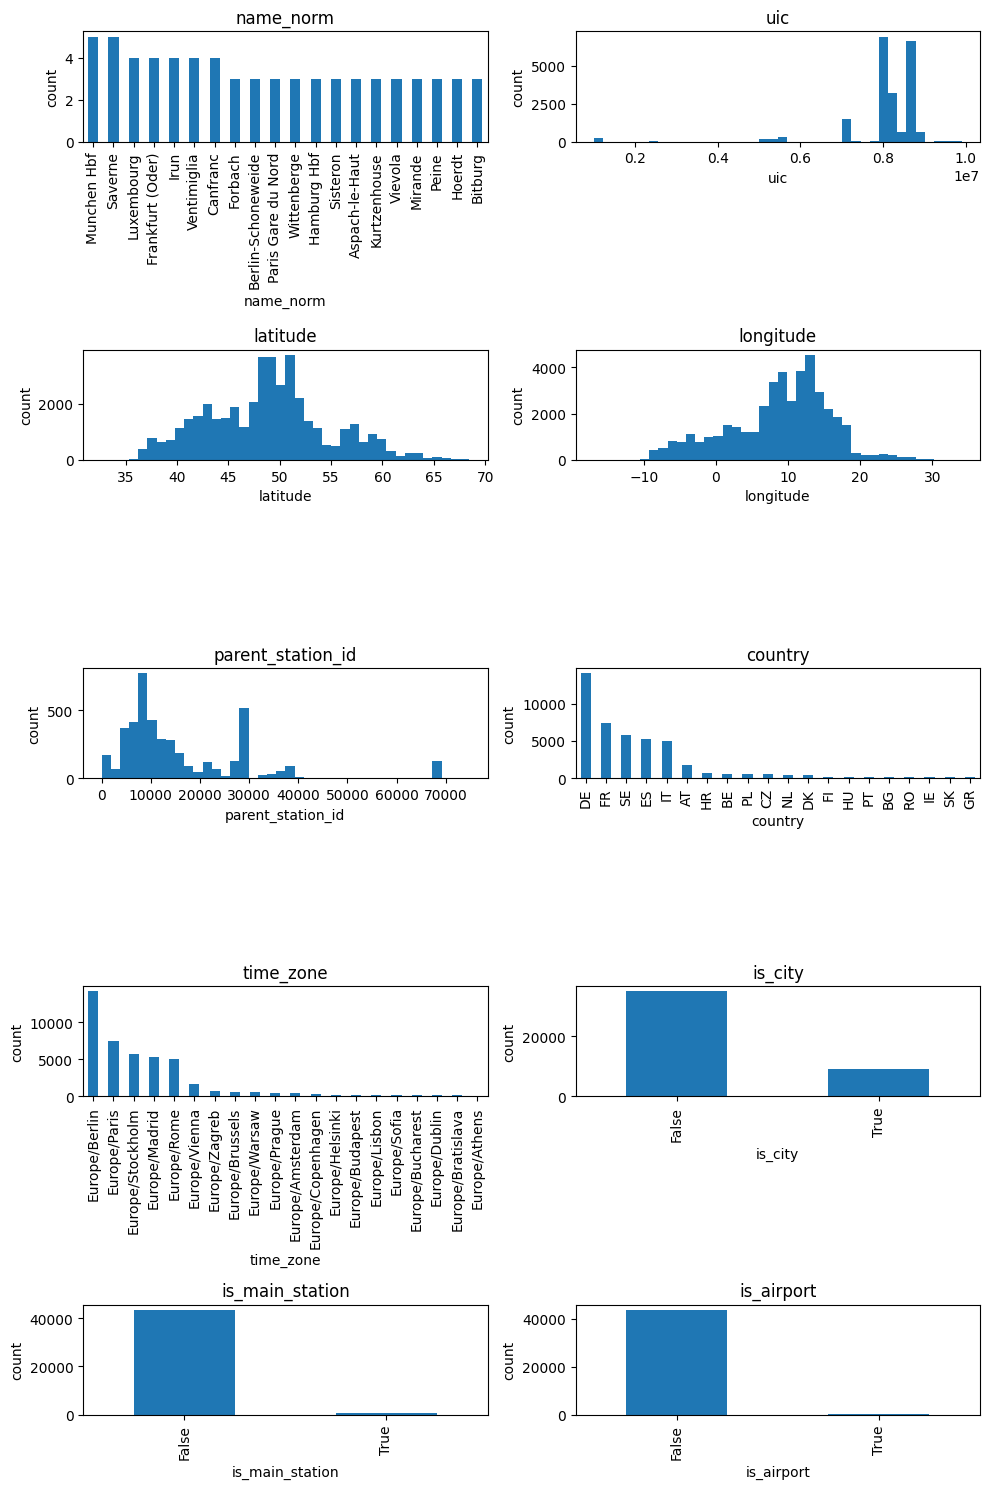

In [9]:
visualize_columns_for_consistency(df_stations)

Interpretation: missingness, duplicates, and distribution shapes highlight where imputation
and deduplication will be required before any spatial analysis.


#### 2.4 Data Quality Verification

This section applies rule-based checks to validate country codes, time zones, and geographic ranges.


##### Validity checks and expectations


In [10]:
from zoneinfo import available_timezones

# ISO 3166-1 alpha-2 list for validation
ISO_ALPHA2 = {
    'AD','AE','AF','AG','AI','AL','AM','AO','AQ','AR','AS','AT','AU','AW','AX','AZ',
    'BA','BB','BD','BE','BF','BG','BH','BI','BJ','BL','BM','BN','BO','BQ','BR','BS','BT','BV','BW','BY','BZ',
    'CA','CC','CD','CF','CG','CH','CI','CK','CL','CM','CN','CO','CR','CU','CV','CW','CX','CY','CZ',
    'DE','DJ','DK','DM','DO','DZ',
    'EC','EE','EG','EH','ER','ES','ET',
    'FI','FJ','FK','FM','FO','FR',
    'GA','GB','GD','GE','GF','GG','GH','GI','GL','GM','GN','GP','GQ','GR','GS','GT','GU','GW','GY',
    'HK','HM','HN','HR','HT','HU',
    'ID','IE','IL','IM','IN','IO','IQ','IR','IS','IT',
    'JE','JM','JO','JP',
    'KE','KG','KH','KI','KM','KN','KP','KR','KW','KY','KZ',
    'LA','LB','LC','LI','LK','LR','LS','LT','LU','LV','LY',
    'MA','MC','MD','ME','MF','MG','MH','MK','ML','MM','MN','MO','MP','MQ','MR','MS','MT','MU','MV','MW','MX','MY','MZ',
    'NA','NC','NE','NF','NG','NI','NL','NO','NP','NR','NU','NZ',
    'OM',
    'PA','PE','PF','PG','PH','PK','PL','PM','PN','PR','PS','PT','PW','PY',
    'QA',
    'RE','RO','RS','RU','RW',
    'SA','SB','SC','SD','SE','SG','SH','SI','SJ','SK','SL','SM','SN','SO','SR','SS','ST','SV','SX','SY','SZ',
    'TC','TD','TF','TG','TH','TJ','TK','TL','TM','TN','TO','TR','TT','TV','TW','TZ',
    'UA','UG','UM','US','UY','UZ',
    'VA','VC','VE','VG','VI','VN','VU',
    'WF','WS',
    'YE','YT',
    'ZA','ZM','ZW'
}

invalid_countries = df_stations.loc[~df_stations['country'].isin(ISO_ALPHA2), 'country'].unique()
valid_tz = available_timezones()
invalid_time_zones = df_stations.loc[~df_stations['time_zone'].isin(valid_tz), 'time_zone'].unique()

invalid_lat = df_stations['latitude'].dropna().loc[(df_stations['latitude'] < -90) | (df_stations['latitude'] > 90)].shape[0]
invalid_lon = df_stations['longitude'].dropna().loc[(df_stations['longitude'] < -180) | (df_stations['longitude'] > 180)].shape[0]

print('Invalid country codes:', invalid_countries)
print('Invalid time zones:', invalid_time_zones)
print('Invalid latitude count:', invalid_lat)
print('Invalid longitude count:', invalid_lon)


Invalid country codes: []
Invalid time zones: []
Invalid latitude count: 0
Invalid longitude count: 0


Interpretation: any invalid country codes, time zones, or out-of-range coordinates would be
flagged for correction or exclusion. This validates the data boundaries before preparation.


### CRISP-DM Step 3: Data Preparation

Goal: construct a clean, analysis-ready dataset through selection, cleaning, and formatting
while preserving traceability of imputed values.


#### 3.1 Select & Prepare Working Dataset


We create a working copy from the scoped dataset and normalize station names to support
matching and duplicate detection in later steps.


In [11]:
# Use the filtered dataset loaded earlier
stations = df_stations.copy()

# Standardize station names for matching
stations['name_norm'] = stations['name_norm'].astype('string').str.strip()


#### 3.2 Handle Missing Values and Duplicates


In [12]:
# Impute missing lat/lon from parent_station_id where available
missing_geo = stations['latitude'].isna() | stations['longitude'].isna()

# Map parent coordinates when parent exists
parent_coords = stations[['latitude', 'longitude']].copy()
parent_coords.columns = ['parent_lat', 'parent_lon']

stations = stations.join(parent_coords, on='parent_station_id')

# Fill missing coordinates from parent
stations.loc[missing_geo, 'latitude'] = stations.loc[missing_geo, 'latitude'].fillna(stations.loc[missing_geo, 'parent_lat'])
stations.loc[missing_geo, 'longitude'] = stations.loc[missing_geo, 'longitude'].fillna(stations.loc[missing_geo, 'parent_lon'])

# Drop helper columns
stations.drop(columns=['parent_lat', 'parent_lon'], inplace=True)

# Country-level median fallback for any remaining missing coordinates
country_medians = stations.groupby('country')[['latitude', 'longitude']].median()

still_missing = stations['latitude'].isna() | stations['longitude'].isna()
stations.loc[still_missing, 'latitude'] = stations.loc[still_missing, 'latitude'].fillna(
    stations.loc[still_missing, 'country'].map(country_medians['latitude'])
)
stations.loc[still_missing, 'longitude'] = stations.loc[still_missing, 'longitude'].fillna(
    stations.loc[still_missing, 'country'].map(country_medians['longitude'])
)

remaining_missing = (stations['latitude'].isna() | stations['longitude'].isna()).sum()
print('Remaining missing lat/lon after country median:', remaining_missing)

# Track rows where original coords were missing
stations['geo_imputed'] = missing_geo

# Drop rows missing name_norm (single missing value)
before_name = len(stations)
stations = stations.dropna(subset=['name_norm'])
print('Dropped rows missing name_norm:', before_name - len(stations))

# Remove exact duplicate rows
before_dups = len(stations)
stations = stations.drop_duplicates(keep='first')
print('Dropped exact duplicate rows:', before_dups - len(stations))

# Remove near duplicates on key fields (keep first)
key_cols = ['name_norm', 'country', 'latitude', 'longitude']
near_before = len(stations)
stations = stations.drop_duplicates(subset=key_cols, keep='first')
print('Dropped near-duplicate rows:', near_before - len(stations))


Remaining missing lat/lon after country median: 0
Dropped rows missing name_norm: 1
Dropped exact duplicate rows: 9
Dropped near-duplicate rows: 85


Interpretation: parent-station and country-median imputations minimize coordinate gaps while
retaining geographic plausibility; duplicate removal stabilizes counts for later EDA.


#### 3.3 Final Feature Set and Export


In [13]:
# Define final feature set
final_columns = [
    'name_norm',
    'uic',
    'latitude',
    'longitude',
    'parent_station_id',
    'country',
    'time_zone',
    'is_city',
    'is_main_station',
    'is_airport',
    'geo_imputed',
]

final_columns = [c for c in final_columns if c in stations.columns]
cleaned = stations[final_columns].copy()

# Export cleaned dataset
out_path = Path('..') / 'Processed_Data' / 'train_stations_europe_cleaned.csv'
cleaned.to_csv(out_path, index=True)

# Quick summary
summary = {
    'rows': len(cleaned),
    'columns': len(cleaned.columns),
    'missing_lat': int(cleaned['latitude'].isna().sum()),
    'missing_lon': int(cleaned['longitude'].isna().sum()),
    'unique_countries': int(cleaned['country'].nunique()),
}
print(summary)


{'rows': 43866, 'columns': 11, 'missing_lat': 0, 'missing_lon': 0, 'unique_countries': 27}


Result: a compact feature set is exported to the processed dataset, with an imputation flag
to support transparency in downstream analysis.


### 4. EDA: Distriptive Insights

EDA is part of CRISP-DM Step 2, but it is executed here on the prepared dataset to ensure
clean, comparable geographic summaries.


#### 4.1 Geographic distribution of stations


In [14]:
# Map plot of station locations using Plotly (higher coastline resolution)
import plotly.express as px

fig = px.scatter_geo(
    cleaned,
    lat='latitude',
    lon='longitude',
    color='country',
    title='Train station locations across EU-27',
    opacity=0.6,
    height=650,
)
fig.update_traces(marker=dict(size=4))
fig.update_geos(
    scope='europe',
    resolution=50,
    showland=True,
    landcolor='rgb(240, 240, 240)',
    showcountries=True,
    showsubunits=True,
    showcoastlines=True,
    coastlinecolor='rgb(80, 80, 80)',
    fitbounds='locations'
)
fig.show()


#### 4.2 Stations per country (histogram)


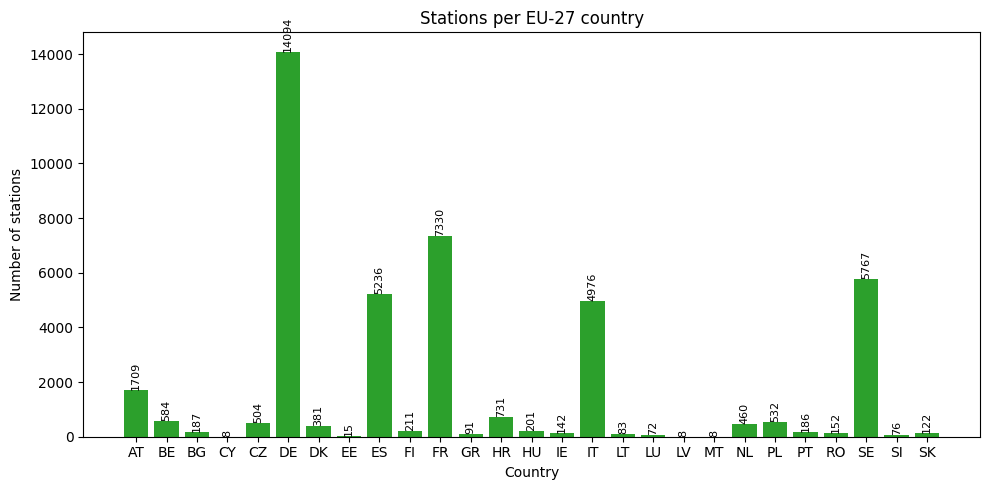

In [15]:
country_counts = cleaned['country'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
ax = plt.gca()
ax.bar(country_counts.index, country_counts.values, color='tab:green')
plt.title('Stations per EU-27 country')
plt.xlabel('Country')
plt.ylabel('Number of stations')

# Add value labels on bars
for i, v in enumerate(country_counts.values):
    ax.text(i, v, str(v), ha='center', va='bottom', fontsize=8, rotation=90)

plt.tight_layout()
plt.show()
